In [113]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import statsmodels.api as sm

from statsmodels.formula.api import ols
from scipy.stats import ttest_ind, pearsonr

In [114]:
with open("new_match_stats.json") as file:
    matches = json.loads(file.read())
stat_keys = matches[0]['home'].keys()
data = {}
data.update({'home_' + k: [] for k in stat_keys})
data.update({'guest_' + k: [] for k in stat_keys})

for match in matches:
    for key in match['home'].keys():
        data['home_' + key].append(match['home'][key])
    for key in match['guest'].keys():
        data['guest_' + key].append(match['guest'][key])

df = pd.DataFrame(data)

In [115]:
columns = ['Команда','Игрок','Позиция','Рост']
df_players = pd.read_table('information.tsv',sep=',', header=None,names=columns,skiprows=1)
df_players=df_players.iloc [1: , :]
df_players.loc[(df_players['Команда'] =='AFC Bournemouth'), 'Команда'] ='Bournemouth'
df_players.loc[(df_players['Команда'] =='Brighton and Hove Albion'), 'Команда'] ='Brighton & Hove Albion'
df_players.head()

,Команда,Игрок,Позиция,Рост
1,Manchester United,David de Gea,Goalkeeper,192cm
2,Manchester United,Tom Heaton,Goalkeeper,188cm
3,Manchester United,Tom Heaton,Goalkeeper,188cm
4,Manchester United,Nathan Bishop,Goalkeeper,185cm
5,Manchester United,Jack Butland,Goalkeeper,196cm


In [116]:
df_players["Рост"] = df_players["Рост"].str.replace(r"[^\d\.]", "", regex=True)
df_players["Рост"] = df_players["Рост"].astype (int)
df_players['Рост_м'] = (df_players['Рост'])/100
df_players.head()

,Команда,Игрок,Позиция,Рост,Рост_м
1,Manchester United,David de Gea,Goalkeeper,192,1.92
2,Manchester United,Tom Heaton,Goalkeeper,188,1.88
3,Manchester United,Tom Heaton,Goalkeeper,188,1.88
4,Manchester United,Nathan Bishop,Goalkeeper,185,1.85
5,Manchester United,Jack Butland,Goalkeeper,196,1.96


In [117]:
df_weather.loc[(df_weather['Город'] =='Брэдфорд'), 'Город'] = 'Брентфорд'
df_weather.loc[(df_weather['Город'] =='Уольверхэмптон'), 'Город'] = 'Вулверхэмптон'
df_weather.loc[(df_weather['Город'] =='Брайтон'), 'Город'] = 'Брайтон энд Хоув'


In [118]:
def assign_value(self):
    if str(self['Позиция']) =='Goalkeeper':
        return '0.5'
    else:
        return '1'

In [119]:
df_players['Веса'] = df_players.apply(assign_value, axis=1)
df_players.head()


,Команда,Игрок,Позиция,Рост,Рост_м,Веса
1,Manchester United,David de Gea,Goalkeeper,192,1.92,0.5
2,Manchester United,Tom Heaton,Goalkeeper,188,1.88,0.5
3,Manchester United,Tom Heaton,Goalkeeper,188,1.88,0.5
4,Manchester United,Nathan Bishop,Goalkeeper,185,1.85,0.5
5,Manchester United,Jack Butland,Goalkeeper,196,1.96,0.5


In [120]:
df_players["Веса"] = df_players["Веса"].astype (float) #добавляем веса, уменьшая вес для вратаря, чтобы далее проверить корреляцию с угловыми
mean_height = df_players.groupby('Команда').agg({'Рост': lambda x: np.average(x, weights=df_players.loc[x.index, 'Веса'])})
mean_height.head()

,Рост
Команда,
Arsenal,179.838235
Aston Villa,182.056604
Bournemouth,181.691176
Brentford,180.967213
Brighton & Hove Albion,179.322034


In [121]:
teams=mean_height.index.tolist() # создаем лист с командами для группировки

In [122]:
data=[]
for team in teams:
    corners=0
    goals=0
    tries=0
    for i in range(len(df)):
        if df['home_team'][i]==team:
            corners+=df['home_corners'][i].astype(int)
            tries+=df['home_goal_kicks'][i].astype(int)
            goals+=df['home_score'][i].astype(int)
        if df['guest_team'][i]==team:
            corners+=df['guest_corners'][i].astype(int)
            tries+=df['guest_goal_kicks'][i].astype(int)
            goals+=df['guest_score'][i].astype(int)
    data.append({'Команда': team, 'Угловые': corners,'Удары по воротам':tries,'Забито':goals})
merged=pd.DataFrame(data)
merged=merged.set_index('Команда')
merged_df = pd.merge(merged, mean_height, on='Команда', how='outer')
merged_df.head()

,Угловые,Удары по воротам,Забито,Рост
Команда,,,,
Arsenal,1049,1182,327,179.838235
Aston Villa,737,1104,192,182.056604
Bournemouth,508,908,127,181.691176
Brentford,299,529,96,180.967213
Brighton & Hove Albion,939,1250,210,179.322034


__Нулевая гипотеза: Команды со средним ростом ниже забивают чаще.__
$$
\begin{aligned}
& H_0: \mu_{high} > \mu_{low} \\
& H_1: \mu_{high} = \mu_{low}
\end{aligned}
$$

Мои напарники запретили мне фэтшеймить игроков, так что как-то так.

In [123]:
corr_1, p_val_1 = pearsonr(merged_df['Рост'], merged_df['Угловые'])
corr_2, p_val_2 = pearsonr(merged_df['Рост'], merged_df['Забито'])
# Уровень значимости: 0.05
alpha = 0.05

if p_val_1 < alpha:
    print('Связь между средним ростом игроков и количеством угловых ударов имеется')
else:
    print('Связи нет')
if p_val_2 < alpha:
    print('Связь между средним ростом игроков и количеством угловых ударов имеется')
else:
    print('Связи нет, можно предположить, что игроки с меньшим средним ростом чаще забивают')


Связи нет
Связи нет, можно предположить, что игроки с меньшим средним ростом чаще забивают


In [124]:
high_height = merged_df[merged_df['Рост'].astype(float) > merged_df['Рост'].astype(float).mean()]
low_height = merged_df[merged_df['Рост'].astype(float) <= merged_df['Рост'].astype(float).mean()]

# Проводим t-тест для групп матчей c разной температурой
# Уровень значимости: 0.05
alpha = 0.05
t_stat, p_val = ttest_ind(low_height['Забито'],high_height['Забито'])

print('t-статистика:', t_stat)
print('значение p:', p_val)

if p_val < alpha:
    print('Нулевая гипотеза не отвергается: команды со средним ростом ниже забивают чаще')
else:
    print('Нулевая гипотеза отвергается: значимого различия нет')



t-статистика: 0.5181985421751383
значение p: 0.6106310249737097
Нулевая гипотеза отвергается: значимого различия нет


In [125]:
regression = ols('Забито ~ Рост', data = merged_df).fit()
print(regression.summary())


                            OLS Regression Results                            
Dep. Variable:                 Забито   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                 -0.039
Method:                 Least Squares   F-statistic:                    0.2810
Date:                Wed, 14 Jun 2023   Prob (F-statistic):              0.603
Time:                        22:31:05   Log-Likelihood:                -120.73
No. Observations:                  20   AIC:                             245.5
Df Residuals:                      18   BIC:                             247.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2182.4163   3683.186      0.593      0.5

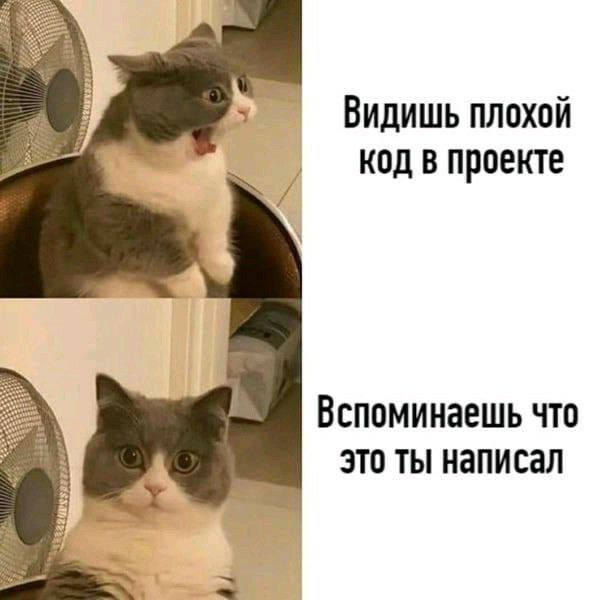